In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits

In [61]:
from mockphot import read_utils, cataloger

In [4]:
sdss = read_utils.SDSSFilters('../data/filters/sdss/filter_curves.fits')                

In [5]:
merian = read_utils.MerianFilters ()
for parname in glob.glob('../data/filters/merian/*par'):
    merian.load( parname )

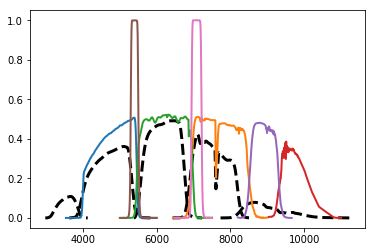

In [6]:
for name in sdss.filter_names:
    plt.plot ( sdss[name].wavelength, sdss[name].transmission, color='k', lw=3, ls='--' )
for name in merian.filter_names:
    plt.plot ( merian[name].wavelength, merian[name].transmission, lw=2)

In [7]:
# \\ Read GAMA spectral catalog
specdf = pd.read_csv ( '../data/queries/GAMA_Od4bFZ.csv')
specdf = specdf.loc[~specdf.set_index('CATAID').index.duplicated()]

In [65]:
gamacat = cataloger.GAMACatalog ( '../data/queries/GAMA_Od4bFZ.csv' )
specdf = gamacat.catalog

In [239]:
# \\ Measure synthetic photometry from spectra 
specphotdf = pd.DataFrame ( index=specdf.index, columns=merian.filter_names )
for idx in specdf.index:
    fname = '../data/queries/GAMA_GuChrO21/' + os.path.basename(specdf.loc[idx,'URL'])
    spec = read_utils.GAMASpectrum ( fname )
    for filt in merian.filter_names:
        mag, magerr = merian[filt].getmag ( spec.wavelength, spec.flux, spec.flux_error )
        specphotdf.loc[idx, filt] = mag
        specphotdf.loc[idx, filt + '_err'] = magerr
    #for filt in sdss.filter_names:
    #    mag, magerr = sdss[filt].getmag ( spec.wavelength, spec.flux, spec.flux_error )
    #    specphotdf.loc[idx, filt] = mag
    #    specphotdf.loc[idx, filt + '_err'] = magerr        
    specphotdf.loc[idx, 'Z'] = specdf.loc[idx,'Z']
specphotdf = specphotdf.loc[~specphotdf.index.duplicated()]

/Users/kadofong/work/merian/merian_mockphot/mockphot/mockphot/read_utils.py:52: RuntimeWarning: invalid value encountered in log10
  


In [241]:
columns = [ x.split(',') for x in open('../data/queries/hsc_query_columns.txt','r').read().splitlines() ]
columns = [ x.strip() for x in np.concatenate(columns)]
columns = list(filter(None,columns))
columns = np.asarray(columns)
for i,k in enumerate(columns):
    if '.' in k:
        columns[i] = k.split('.')[1]

crossphot = pd.read_csv ('../data/queries/hsc_query_res.txt', delim_whitespace=True,
                names=columns)

In [242]:
# \\ Load server-side HSC crossmatch and HSC photometry SQL query results
qname = '../data/queries/376668.csv'
#crossphot = pd.read_csv( qname, comment='#',
#                        names=open(qname,'r').read().splitlines()[0].split()[1].split(',') )
crossmatch = np.load('/Users/kadofong/Downloads/ea162d6fdeb141018aa9c6317408c907.npy')

In [243]:
# \\ Index all by CATAID
crossphot['CATAID'] = crossmatch[np.in1d(crossmatch['db_id'], crossphot['db_id'])]['CATAID']
crossphot = crossphot.set_index("CATAID")

crossphot = crossphot.loc[~crossphot.index.duplicated()]

Text(0,0.5,'m$_{\\rm HSC, cat}$ ')

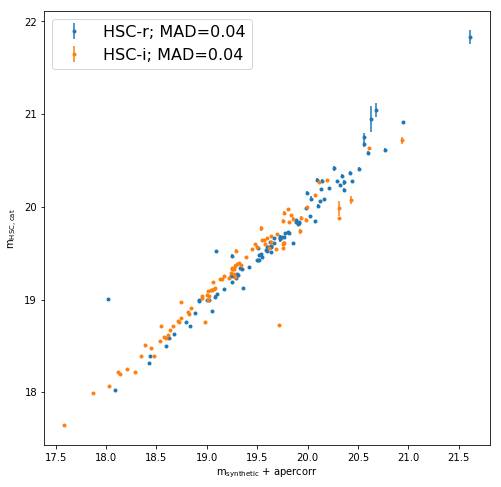

In [244]:
# \\ Plot difference in aperture corrected magnitudes
fig = plt.figure (figsize=(8,8))
ax = plt.subplot(111)
for i,xa in enumerate('ri'):
    diff = (specphotdf[f'hsc_{xa}'] - apercorr) - crossphot[f'{xa}_{label}']
    mad = np.median ( abs(diff-np.median(diff)) )         
    plt.errorbar ( crossphot[f'{xa}_{label}'], 
                 (specphotdf[f'hsc_{xa}'] - apercorr),
                 yerr=specphotdf[f'hsc_{xa}_err'], fmt='o', markersize=3, label=f'HSC-{xa}; MAD={mad:.2f}')
    ymin,ymax = np.quantile ( diff, [.25, .75] )
    #plt.axhline ( ymin, color=f'C{i}', ls=':')
    #plt.axhline ( ymax, color=f'C{i}', ls=':')
 
plt.legend (fontsize=16)    
plt.xlabel(r'm$_{\rm synthetic}$ + apercorr')
plt.ylabel(r'm$_{\rm HSC, cat}$ ')



In [245]:
# \\ Measure average aperture correction from r & i bands
label = 'convolvedflux_0_20_mag'
apercorr_i = specphotdf['hsc_i'] - crossphot[f'i_{label}']
apercorr_r = specphotdf['hsc_r'] - crossphot[f'r_{label}']
apercorr = 0.5*(apercorr_i+apercorr_r)

(17.0, 22.0)

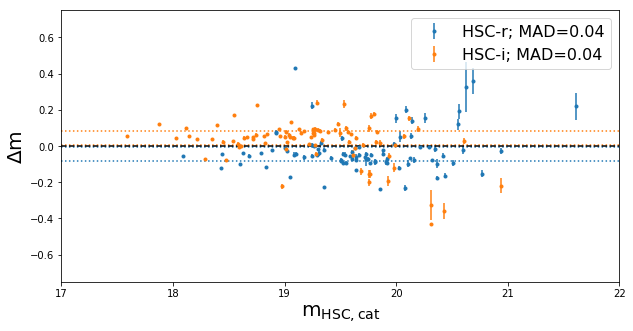

In [246]:
# \\ Plot difference in aperture corrected magnitudes
fig = plt.figure (figsize=(10,5))
ax = plt.subplot(111)
for i,xa in enumerate('ri'):
    diff = (specphotdf[f'hsc_{xa}'] - apercorr) - crossphot[f'{xa}_{label}']
    mad = np.median ( abs(diff-np.median(diff)) )         
    plt.errorbar ( crossphot[f'{xa}_{label}'], 
                 (specphotdf[f'hsc_{xa}'] - apercorr) - crossphot[f'{xa}_{label}'],
                 yerr=specphotdf[f'hsc_{xa}_err'], fmt='o', markersize=3, label=f'HSC-{xa}; MAD={mad:.2f}')
    ymin,ymax = np.quantile ( diff, [.25, .75] )
    plt.axhline ( ymin, color=f'C{i}', ls=':')
    plt.axhline ( ymax, color=f'C{i}', ls=':')
 
plt.legend (fontsize=16)    
plt.xlabel(r'm$_{\rm HSC, cat}$', fontsize=20)
plt.ylabel(r'$\Delta \rm m$ ', fontsize=20)
plt.axhline(0., color='k', ls='--')
plt.ylim(-0.75,0.75)
plt.xlim(17.,22.)

(-0.5, 0.1)

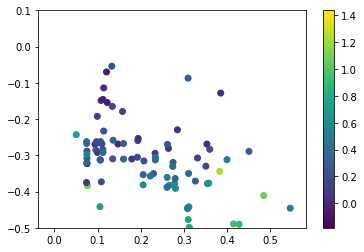

In [247]:
#plt.scatter ( specphotdf['Z'], specphotdf['N708'] - apercorr - crossphot['r_cmodel_mag'], fmt='o', markersize=3)
plt.scatter ( specphotdf['Z'], specphotdf['N708'] - apercorr - crossphot[f'r_{label}'],
             c=specphotdf['N540'] - apercorr - crossphot[f'r_{label}'],  )
plt.colorbar()
plt.ylim(-0.5,.1)

In [248]:
from astropy import units as u

In [258]:
label

'convolvedflux_0_20_mag'

In [257]:
crossphot[f'g_{label}err']

CATAID
6802    0.000853
6806    0.002414
6808    0.002178
6810    0.002324
6813    0.003114
6816    0.002176
6820    0.003933
6821    0.000680
6830    0.002357
6835    0.009434
6837    0.001048
6838    0.001495
6839    0.001837
6840    0.001218
6842    0.001536
6845    0.001301
6846    0.001672
6853    0.000675
6855    0.001119
6856    0.001075
6858    0.001494
6860    0.001150
6861    0.001135
6878    0.002521
6880    0.000611
6882    0.000547
6884    0.000964
6886    0.000906
6889    0.001646
6891    0.003425
          ...   
6983    0.002036
6988    0.002293
6998    0.000933
6999    0.001137
7000    0.001355
7001    0.000963
7002    0.002049
7003    0.000854
7004    0.001356
7005    0.001094
7007    0.001518
7008    0.001009
7010    0.001293
7011    0.000746
7014    0.002388
7015    0.002153
7017    0.002186
7019    0.001991
7024    0.001810
7025    0.001950
7026    0.002269
7029    0.003032
7030    0.003508
7032    0.002558
7039    0.000862
7040    0.001573
7043    0.001774
7045   

In [261]:
# \\ build catalog in nanoMaggies
pkgdf = pd.DataFrame(index=specdf.index)

nanomaggy_per_jy = 3.631e-6


In [275]:
nanomag = pd.DataFrame()
for filt in ['N540','N708']:
    mag = specphotdf[filt].astype(float) - apercorr.astype(float)
    if np.isnan(mag).all():
        continue
    nmf = 10.**((mag - 8.9)/-2.5) / nanomaggy_per_jy
    nanomag[filt+"_synth"] = nmf
    nanomag[filt+'_synth_err'] = 0.4 * np.log(10.) * nmf * specphotdf[filt+"_err"]
     
for filt in 'grizy':
    nmf_cat = 10.**((crossphot[f'{filt}_{label}'] - 8.9)/-2.5) / nanomaggy_per_jy
    nanomag['hsc_'+filt+'_cat'] = nmf_cat
    nanomag['hsc_'+filt+'_cat_err'] = 0.4 * np.log(10.) * nmf * crossphot[f'{filt}_{label}err']

In [277]:
nanomag.to_csv('/Users/kadofong/Downloads/initialsubset_GAMAsynths.csv')

In [80]:
for ff in 'grizy':
    for i in range(4):
        print(f'f.{ff}_convolvedflux_{i}_20_mag, f.{ff}_convolvedflux_{i}_20_magerr, f.{ff}_convolvedflux_{i}_20_apcorr, f.{ff}_convolvedflux_{i}_20_apcorrerr,')

f.g_convolvedflux_0_20_mag, f.g_convolvedflux_0_20_magerr, f.g_convolvedflux_0_20_apcorr, f.g_convolvedflux_0_20_apcorrerr,
f.g_convolvedflux_1_20_mag, f.g_convolvedflux_1_20_magerr, f.g_convolvedflux_1_20_apcorr, f.g_convolvedflux_1_20_apcorrerr,
f.g_convolvedflux_2_20_mag, f.g_convolvedflux_2_20_magerr, f.g_convolvedflux_2_20_apcorr, f.g_convolvedflux_2_20_apcorrerr,
f.g_convolvedflux_3_20_mag, f.g_convolvedflux_3_20_magerr, f.g_convolvedflux_3_20_apcorr, f.g_convolvedflux_3_20_apcorrerr,
f.r_convolvedflux_0_20_mag, f.r_convolvedflux_0_20_magerr, f.r_convolvedflux_0_20_apcorr, f.r_convolvedflux_0_20_apcorrerr,
f.r_convolvedflux_1_20_mag, f.r_convolvedflux_1_20_magerr, f.r_convolvedflux_1_20_apcorr, f.r_convolvedflux_1_20_apcorrerr,
f.r_convolvedflux_2_20_mag, f.r_convolvedflux_2_20_magerr, f.r_convolvedflux_2_20_apcorr, f.r_convolvedflux_2_20_apcorrerr,
f.r_convolvedflux_3_20_mag, f.r_convolvedflux_3_20_magerr, f.r_convolvedflux_3_20_apcorr, f.r_convolvedflux_3_20_apcorrerr,
f.i_conv